#Ventilator

In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

%matplotlib inline

In [3]:
path = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

# 간단 EDA

- id: globally-unique time step identifier across an entire file **전체 번호**
- breath_id: globally-unique time step for breaths **각 환자 번호**
- R: lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow. **기도가 얼마나 막혔는지(음료를 빨대로 마실 때 빨대를 조였다 폈다하는 것과 같다) 흐름 변화당 압력 변화 ~ 높은 R일수록 불기 어렵다**
- C: lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow. **폐의 순응력(같은 부피라도 풍선에 재질에 따라 쉽게 불러지는 것이 있고 어려운 것이 있다) 압력 변화당 부피 변화 ~ 높은 C 일수록 쉽게 불러진다**
- time_step: the actual time stamp. **각 환자의 타임스텝**
- u_in: the control input for the inspiratory solenoid valve. Ranges from 0 to 100. **inspiratory solenoid valve 흡기 벨브(?) [0.100]**
- u_out: the control input for the exploratory solenoid valve. Either 0 or 1. **exploratory solenoid valve 예비 벨브(?) 0 or 1**
- pressure: the airway pressure measured in the respiratory circuit, measured in cmH2O. **공기압(Target)**

In [ ]:
print(train.shape)
train.tail()

(6036000, 8)


,id,breath_id,R,C,time_step,u_in,u_out,pressure
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938
6035999,6036000,125749,50,10,2.638017,1.482739,1,3.869032


In [ ]:
print(test.shape)
test.head()

(4024000, 7)


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [ ]:
train.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


In [ ]:
train['R'].unique()

array([20, 50,  5])

In [ ]:
train['C'].unique()

array([50, 20, 10])

breath_id 당 개수 확인

A: 모두 80개씩

In [ ]:
print('breath_id 개수 :', len(train['breath_id'].unique()))
print('breath_id 당 개수 :', train['breath_id'].value_counts().unique())

breath_id 개수 : 75450
breath_id 당 개수 : [80]


In [ ]:
train[train['breath_id'] == 8] ## 일부는 test에 있다.

,id,breath_id,R,C,time_step,u_in,u_out,pressure


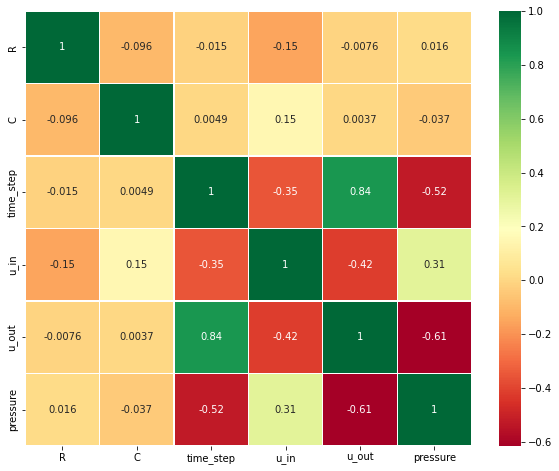

In [ ]:
sns.heatmap(train.drop(['id', 'breath_id'], axis=1).corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

# Feature Engineering

## Train

R과 C를 원핫 인코딩

In [4]:
train = pd.get_dummies(train, columns=['R', 'C'], prefix=['R', 'C'], prefix_sep='')
R_col = ['R5', 'R20', 'R50']
C_col = ['C10', 'C20', 'C50']
for r in R_col:
    for c in C_col:
        train.loc[:, r+'_'+c] = train[r]*train[c]

train = train.drop(R_col+C_col, axis=1)

del R_col
del C_col

In [5]:
train.loc[:, 'in0'] = (train['u_in'] == 0).astype(float)
train.loc[:, 'in1'] = (train['u_in'] != 0).astype(float)

train.loc[:, 'in0_out0'] = abs(train['in0'] * (train['u_out'] - 1))
train.loc[:, 'in0_out1'] = train['in0'] * train['u_out']
train.loc[:, 'in1_out0'] = abs(train['u_in'] * (train['u_out'] - 1)) # train['in1'] * (train['u_out'] - 1)*(-1)
train.loc[:, 'in1_out1'] = train['u_in'] * train['u_out'] # train['in1'] * train['u_out']

train = train.drop(['u_in', 'u_out', 'in0', 'in1'], axis=1)

train = train.drop(['id', 'breath_id'], axis=1)

sample_size = 80
total_train_sample_num = train.shape[0] // sample_size # 75450
total_test_sample_num = test.shape[0] // sample_size # 50300

feature_num = train.drop(['pressure', 'R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1).shape[1]
print(feature_num)

5


In [7]:
mu_in1_out0 = train['in1_out0'].mean()
std_in1_out0 = train['in1_out0'].std()
train['in1_out0'] = (train['in1_out0'] - mu_in1_out0) / std_in1_out0
mu_in1_out1 = train['in1_out1'].mean()
std_in1_out1 = train['in1_out1'].std()
train['in1_out1'] = (train['in1_out1'] - mu_in1_out1) / std_in1_out1
mu_time_step = train['time_step'].mean()
std_time_step = train['time_step'].std()
train['time_step'] = (train['time_step'] - mu_time_step) / std_time_step

feature_num = train.drop(['pressure'], axis=1).shape[1]

Specialize data as R and C

Standardize u_in and time

**Standardization일 때 성능 체크**

### Specialization

In [6]:
# standardization
train_R5C10 = train[train['R5_C10'] == 1]
train_R5C10 = train_R5C10.drop(['R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1)
mu_in1_out0_R5C10 = train_R5C10['in1_out0'].mean()
std_in1_out0_R5C10 = train_R5C10['in1_out0'].std()
train_R5C10['in1_out0'] = (train_R5C10['in1_out0'] - mu_in1_out0_R5C10) / std_in1_out0_R5C10
mu_in1_out1_R5C10 = train_R5C10['in1_out1'].mean()
std_in1_out1_R5C10 = train_R5C10['in1_out1'].std()
train_R5C10['in1_out1'] = (train_R5C10['in1_out1'] - mu_in1_out1_R5C10) / std_in1_out1_R5C10
mu_time_step_R5C10 = train_R5C10['time_step'].mean()
std_time_step_R5C10 = train_R5C10['time_step'].std()
train_R5C10['time_step'] = (train_R5C10['time_step'] - mu_time_step_R5C10) / std_time_step_R5C10

train_R5C20 = train[train['R5_C20'] == 1]
train_R5C20 = train_R5C20.drop(['R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1)
mu_in1_out0_R5C20 = train_R5C20['in1_out0'].mean()
std_in1_out0_R5C20 = train_R5C20['in1_out0'].std()
train_R5C20['in1_out0'] = (train_R5C20['in1_out0'] - mu_in1_out0_R5C20) / std_in1_out0_R5C20
mu_in1_out1_R5C20 = train_R5C20['in1_out1'].mean()
std_in1_out1_R5C20 = train_R5C20['in1_out1'].std()
train_R5C20['in1_out1'] = (train_R5C20['in1_out1'] - mu_in1_out1_R5C20) / std_in1_out1_R5C20
mu_time_step_R5C20 = train_R5C20['time_step'].mean()
std_time_step_R5C20 = train_R5C20['time_step'].std()
train_R5C20['time_step'] = (train_R5C20['time_step'] - mu_time_step_R5C20) / std_time_step_R5C20

train_R5C50 = train[train['R5_C50'] == 1]
train_R5C50 = train_R5C50.drop(['R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1)
mu_in1_out0_R5C50 = train_R5C50['in1_out0'].mean()
std_in1_out0_R5C50 = train_R5C50['in1_out0'].std()
train_R5C50['in1_out0'] = (train_R5C50['in1_out0'] - mu_in1_out0_R5C50) / std_in1_out0_R5C50
mu_in1_out1_R5C50 = train_R5C50['in1_out1'].mean()
std_in1_out1_R5C50 = train_R5C50['in1_out1'].std()
train_R5C50['in1_out1'] = (train_R5C50['in1_out1'] - mu_in1_out1_R5C50) / std_in1_out1_R5C50
mu_time_step_R5C50 = train_R5C50['time_step'].mean()
std_time_step_R5C50 = train_R5C50['time_step'].std()
train_R5C50['time_step'] = (train_R5C50['time_step'] - mu_time_step_R5C50) / std_time_step_R5C50

train_R20C10 = train[train['R20_C10'] == 1]
train_R20C10 = train_R20C10.drop(['R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1)
mu_in1_out0_R20C10 = train_R20C10['in1_out0'].mean()
std_in1_out0_R20C10 = train_R20C10['in1_out0'].std()
train_R20C10['in1_out0'] = (train_R20C10['in1_out0'] - mu_in1_out0_R20C10) / std_in1_out0_R20C10
mu_in1_out1_R20C10 = train_R20C10['in1_out1'].mean()
std_in1_out1_R20C10 = train_R20C10['in1_out1'].std()
train_R20C10['in1_out1'] = (train_R20C10['in1_out1'] - mu_in1_out1_R20C10) / std_in1_out1_R20C10
mu_time_step_R20C10 = train_R20C10['time_step'].mean()
std_time_step_R20C10 = train_R20C10['time_step'].std()
train_R20C10['time_step'] = (train_R20C10['time_step'] - mu_time_step_R20C10) / std_time_step_R20C10

train_R20C20 = train[train['R20_C20'] == 1]
train_R20C20 = train_R20C20.drop(['R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1)
mu_in1_out0_R20C20 = train_R20C20['in1_out0'].mean()
std_in1_out0_R20C20 = train_R20C20['in1_out0'].std()
train_R20C20['in1_out0'] = (train_R20C20['in1_out0'] - mu_in1_out0_R20C20) / std_in1_out0_R20C20
mu_in1_out1_R20C20 = train_R20C20['in1_out1'].mean()
std_in1_out1_R20C20 = train_R20C20['in1_out1'].std()
train_R20C20['in1_out1'] = (train_R20C20['in1_out1'] - mu_in1_out1_R20C20) / std_in1_out1_R20C20
mu_time_step_R20C20 = train_R20C20['time_step'].mean()
std_time_step_R20C20 = train_R20C20['time_step'].std()
train_R20C20['time_step'] = (train_R20C20['time_step'] - mu_time_step_R20C20) / std_time_step_R20C20

train_R20C50 = train[train['R20_C50'] == 1]
train_R20C50 = train_R20C50.drop(['R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1)
mu_in1_out0_R20C50 = train_R20C50['in1_out0'].mean()
std_in1_out0_R20C50 = train_R20C50['in1_out0'].std()
train_R20C50['in1_out0'] = (train_R20C50['in1_out0'] - mu_in1_out0_R20C50) / std_in1_out0_R20C50
mu_in1_out1_R20C50 = train_R20C50['in1_out1'].mean()
std_in1_out1_R20C50 = train_R20C50['in1_out1'].std()
train_R20C50['in1_out1'] = (train_R20C50['in1_out1'] - mu_in1_out1_R20C50) / std_in1_out1_R20C50
mu_time_step_R20C50 = train_R20C50['time_step'].mean()
std_time_step_R20C50 = train_R20C50['time_step'].std()
train_R20C50['time_step'] = (train_R20C50['time_step'] - mu_time_step_R20C50) / std_time_step_R20C50

train_R50C10 = train[train['R50_C10'] == 1]
train_R50C10 = train_R50C10.drop(['R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1)
mu_in1_out0_R50C10 = train_R50C10['in1_out0'].mean()
std_in1_out0_R50C10 = train_R50C10['in1_out0'].std()
train_R50C10['in1_out0'] = (train_R50C10['in1_out0'] - mu_in1_out0_R50C10) / std_in1_out0_R50C10
mu_in1_out1_R50C10 = train_R50C10['in1_out1'].mean()
std_in1_out1_R50C10 = train_R50C10['in1_out1'].std()
train_R50C10['in1_out1'] = (train_R50C10['in1_out1'] - mu_in1_out1_R50C10) / std_in1_out1_R50C10
mu_time_step_R50C10 = train_R50C10['time_step'].mean()
std_time_step_R50C10 = train_R50C10['time_step'].std()
train_R50C10['time_step'] = (train_R50C10['time_step'] - mu_time_step_R50C10) / std_time_step_R50C10

train_R50C20 = train[train['R50_C20'] == 1]
train_R50C20 = train_R50C20.drop(['R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1)
mu_in1_out0_R50C20 = train_R50C20['in1_out0'].mean()
std_in1_out0_R50C20 = train_R50C20['in1_out0'].std()
train_R50C20['in1_out0'] = (train_R50C20['in1_out0'] - mu_in1_out0_R50C20) / std_in1_out0_R50C20
mu_in1_out1_R50C20 = train_R50C20['in1_out1'].mean()
std_in1_out1_R50C20 = train_R50C20['in1_out1'].std()
train_R50C20['in1_out1'] = (train_R50C20['in1_out1'] - mu_in1_out1_R50C20) / std_in1_out1_R50C20
mu_time_step_R50C20 = train_R50C20['time_step'].mean()
std_time_step_R50C20 = train_R50C20['time_step'].std()
train_R50C20['time_step'] = (train_R50C20['time_step'] - mu_time_step_R50C20) / std_time_step_R50C20

train_R50C50 = train[train['R50_C50'] == 1]
train_R50C50 = train_R50C50.drop(['R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1)
mu_in1_out0_R50C50 = train_R50C50['in1_out0'].mean()
std_in1_out0_R50C50 = train_R50C50['in1_out0'].std()
train_R50C50['in1_out0'] = (train_R50C50['in1_out0'] - mu_in1_out0_R50C50) / std_in1_out0_R50C50
mu_in1_out1_R50C50 = train_R50C50['in1_out1'].mean()
std_in1_out1_R50C50 = train_R50C50['in1_out1'].std()
train_R50C50['in1_out1'] = (train_R50C50['in1_out1'] - mu_in1_out1_R50C50) / std_in1_out1_R50C50
mu_time_step_R50C50 = train_R50C50['time_step'].mean()
std_time_step_R50C50 = train_R50C50['time_step'].std()
train_R50C50['time_step'] = (train_R50C50['time_step'] - mu_time_step_R50C50) / std_time_step_R50C50

# del train

#### EDA after Feature Engineering

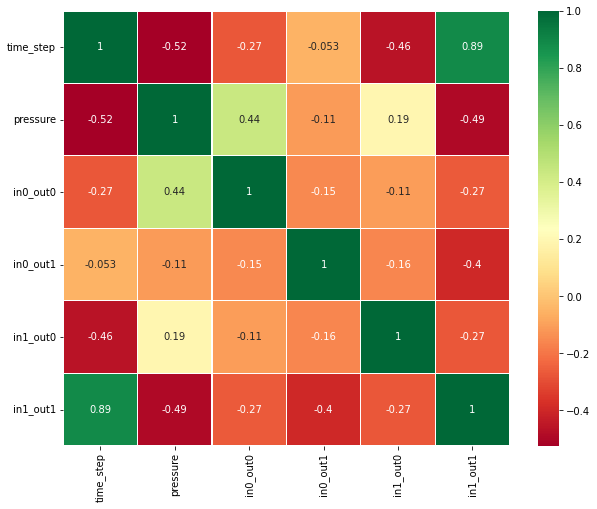

In [12]:
sns.heatmap(train_R5C10.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

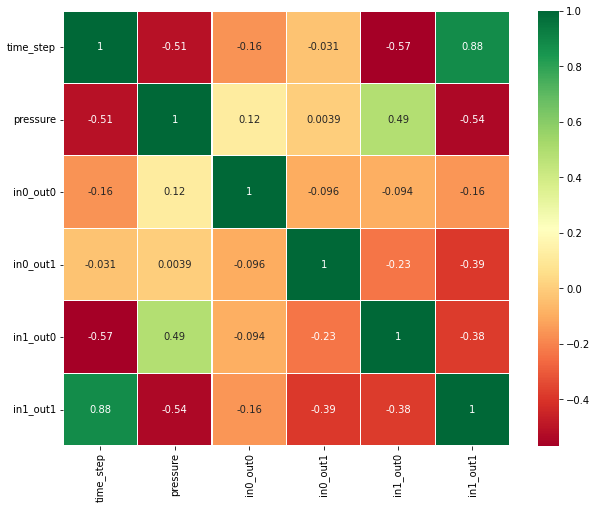

In [13]:
sns.heatmap(train_R5C20.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

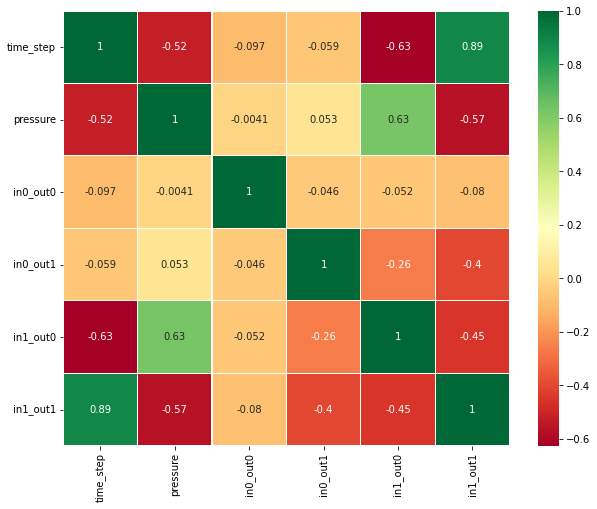

In [14]:
sns.heatmap(train_R5C50.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

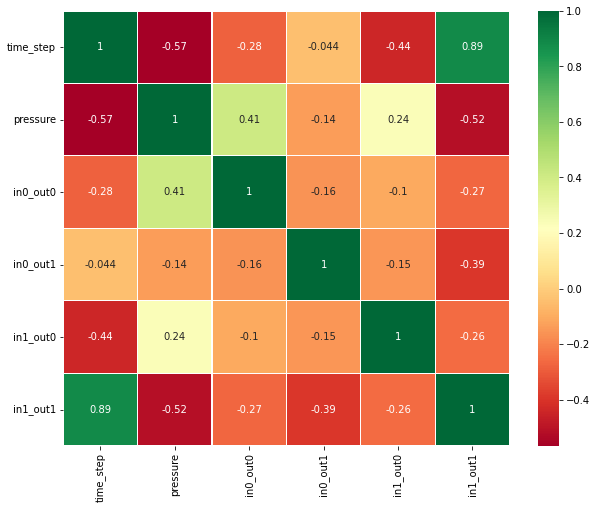

In [15]:
sns.heatmap(train_R20C10.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

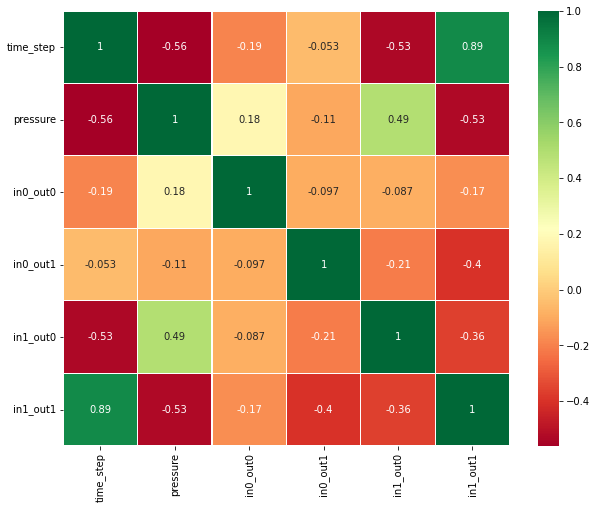

In [16]:
sns.heatmap(train_R20C20.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

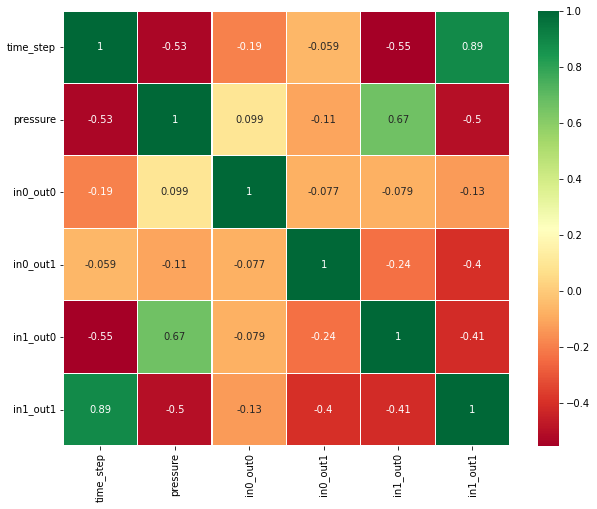

In [17]:
sns.heatmap(train_R20C50.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

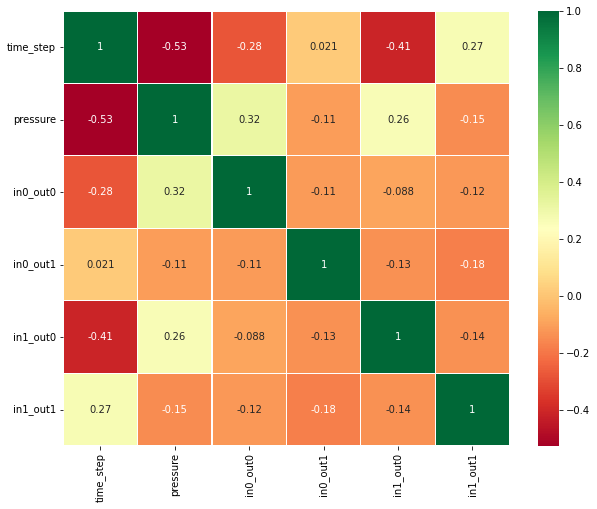

In [18]:
sns.heatmap(train_R50C10.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

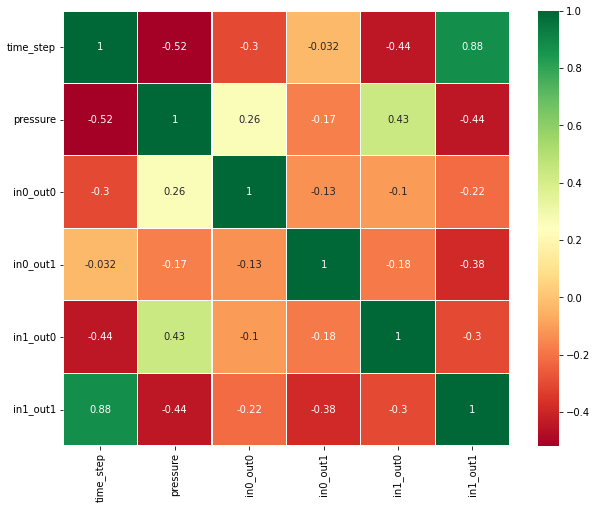

In [19]:
sns.heatmap(train_R50C20.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

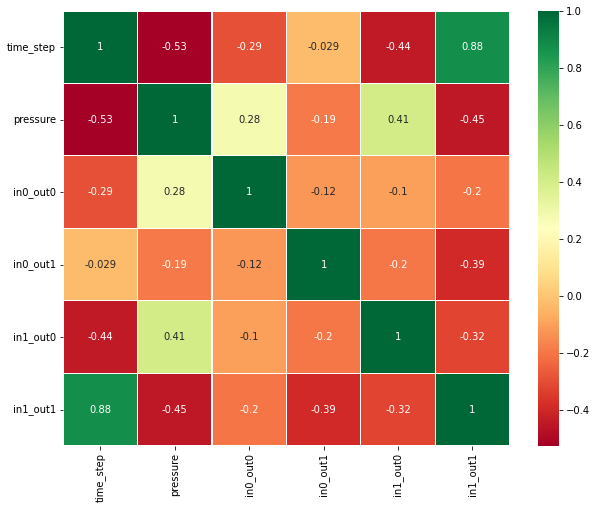

In [20]:
sns.heatmap(train_R50C50.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

## Test

In [ ]:
test = pd.get_dummies(test, columns=['R', 'C'], prefix=['R', 'C'], prefix_sep='')
R_col = ['R5', 'R20', 'R50']
C_col = ['C10', 'C20', 'C50']
for r in R_col:
    for c in C_col:
        test.loc[:, r+'_'+c] = test[r]*test[c]

test = test.drop(R_col+C_col, axis=1)

del R_col
del C_col

In [ ]:
test.loc[:, 'u_1'] = test['u_in'] * test['u_out']
test.loc[:, 'u_0'] = test['u_in'] * ((test['u_out'] - 1)*(-1))

test = test.drop(['u_in', 'u_out'], axis=1)

In [ ]:
test = test.drop(['breath_id'], axis=1)

#test.loc[:, 'time'] = test['time_step'].diff()
#test['time'] = test['time'].fillna(0)
#test.loc[test['time'] < 0, 'time'] = 0

#test = test.drop(['time_step'], axis=1)

In [ ]:
# u_0과 time_step을 standardization하자
test_R5C10 = test[test['R5_C10'] == 1]
test_R5C10 = test_R5C10.drop(['R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1)
mu_u_0_R5C10 = test_R5C10['u_0'].mean()
std_u_0_R5C10 = test_R5C10['u_0'].std()
test_R5C10['u_0'] = (test_R5C10['u_0'] - mu_u_0_R5C10) / std_u_0_R5C10
mu_u_1_R5C10 = test_R5C10['u_1'].mean()
std_u_1_R5C10 = test_R5C10['u_1'].std()
test_R5C10['u_1'] = (test_R5C10['u_1'] - mu_u_1_R5C10) / std_u_1_R5C10
mu_time_step_R5C10 = test_R5C10['time_step'].mean()
std_time_step_R5C10 = test_R5C10['time_step'].std()
test_R5C10['time_step'] = (test_R5C10['time_step'] - mu_time_step_R5C10) / std_time_step_R5C10

test_R5C20 = test[test['R5_C20'] == 1]
test_R5C20 = test_R5C20.drop(['R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1)
mu_u_0_R5C20 = test_R5C20['u_0'].mean()
std_u_0_R5C20 = test_R5C20['u_0'].std()
test_R5C20['u_0'] = (test_R5C20['u_0'] - mu_u_0_R5C20) / std_u_0_R5C20
mu_u_1_R5C20 = test_R5C20['u_1'].mean()
std_u_1_R5C20 = test_R5C20['u_1'].std()
test_R5C20['u_1'] = (test_R5C20['u_1'] - mu_u_1_R5C20) / std_u_1_R5C20
mu_time_step_R5C20 = test_R5C20['time_step'].mean()
std_time_step_R5C20 = test_R5C20['time_step'].std()
test_R5C20['time_step'] = (test_R5C20['time_step'] - mu_time_step_R5C20) / std_time_step_R5C20

test_R5C50 = test[test['R5_C50'] == 1]
test_R5C50 = test_R5C50.drop(['R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1)
mu_u_0_R5C50 = test_R5C50['u_0'].mean()
std_u_0_R5C50 = test_R5C50['u_0'].std()
test_R5C50['u_0'] = (test_R5C50['u_0'] - mu_u_0_R5C50) / std_u_0_R5C50
mu_u_1_R5C50 = test_R5C50['u_1'].mean()
std_u_1_R5C50 = test_R5C50['u_1'].std()
test_R5C50['u_1'] = (test_R5C50['u_1'] - mu_u_1_R5C50) / std_u_1_R5C50
mu_time_step_R5C50 = test_R5C50['time_step'].mean()
std_time_step_R5C50 = test_R5C50['time_step'].std()
test_R5C50['time_step'] = (test_R5C50['time_step'] - mu_time_step_R5C50) / std_time_step_R5C50

test_R20C10 = test[test['R20_C10'] == 1]
test_R20C10 = test_R20C10.drop(['R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1)
mu_u_0_R20C10 = test_R20C10['u_0'].mean()
std_u_0_R20C10 = test_R20C10['u_0'].std()
test_R20C10['u_0'] = (test_R20C10['u_0'] - mu_u_0_R20C10) / std_u_0_R20C10
mu_u_1_R20C10 = test_R20C10['u_1'].mean()
std_u_1_R20C10 = test_R20C10['u_1'].std()
test_R20C10['u_1'] = (test_R20C10['u_1'] - mu_u_1_R20C10) / std_u_1_R20C10
mu_time_step_R20C10 = test_R20C10['time_step'].mean()
std_time_step_R20C10 = test_R20C10['time_step'].std()
test_R20C10['time_step'] = (test_R20C10['time_step'] - mu_time_step_R20C10) / std_time_step_R20C10

test_R20C20 = test[test['R20_C20'] == 1]
test_R20C20 = test_R20C20.drop(['R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1)
mu_u_0_R20C20 = test_R20C20['u_0'].mean()
std_u_0_R20C20 = test_R20C20['u_0'].std()
test_R20C20['u_0'] = (test_R20C20['u_0'] - mu_u_0_R20C20) / std_u_0_R20C20
mu_u_1_R20C20 = test_R20C20['u_1'].mean()
std_u_1_R20C20 = test_R20C20['u_1'].std()
test_R20C20['u_1'] = (test_R20C20['u_1'] - mu_u_1_R20C20) / std_u_1_R20C20
mu_time_step_R20C20 = test_R20C20['time_step'].mean()
std_time_step_R20C20 = test_R20C20['time_step'].std()
test_R20C20['time_step'] = (test_R20C20['time_step'] - mu_time_step_R20C20) / std_time_step_R20C20

test_R20C50 = test[test['R20_C50'] == 1]
test_R20C50 = test_R20C50.drop(['R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1)
mu_u_0_R20C50 = test_R20C50['u_0'].mean()
std_u_0_R20C50 = test_R20C50['u_0'].std()
test_R20C50['u_0'] = (test_R20C50['u_0'] - mu_u_0_R20C50) / std_u_0_R20C50
mu_u_1_R20C50 = test_R20C50['u_1'].mean()
std_u_1_R20C50 = test_R20C50['u_1'].std()
test_R20C50['u_1'] = (test_R20C50['u_1'] - mu_u_1_R20C50) / std_u_1_R20C50
mu_time_step_R20C50 = test_R20C50['time_step'].mean()
std_time_step_R20C50 = test_R20C50['time_step'].std()
test_R20C50['time_step'] = (test_R20C50['time_step'] - mu_time_step_R20C50) / std_time_step_R20C50

test_R50C10 = test[test['R50_C10'] == 1]
test_R50C10 = test_R50C10.drop(['R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1)
mu_u_0_R50C10 = test_R50C10['u_0'].mean()
std_u_0_R50C10 = test_R50C10['u_0'].std()
test_R50C10['u_0'] = (test_R50C10['u_0'] - mu_u_0_R50C10) / std_u_0_R50C10
mu_u_1_R50C10 = test_R50C10['u_1'].mean()
std_u_1_R50C10 = test_R50C10['u_1'].std()
test_R50C10['u_1'] = (test_R50C10['u_1'] - mu_u_1_R50C10) / std_u_1_R50C10
mu_time_step_R50C10 = test_R50C10['time_step'].mean()
std_time_step_R50C10 = test_R50C10['time_step'].std()
test_R50C10['time_step'] = (test_R50C10['time_step'] - mu_time_step_R50C10) / std_time_step_R50C10

test_R50C20 = test[test['R50_C20'] == 1]
test_R50C20 = test_R50C20.drop(['R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1)
mu_u_0_R50C20 = test_R50C20['u_0'].mean()
std_u_0_R50C20 = test_R50C20['u_0'].std()
test_R50C20['u_0'] = (test_R50C20['u_0'] - mu_u_0_R50C20) / std_u_0_R50C20
mu_u_1_R50C20 = test_R50C20['u_1'].mean()
std_u_1_R50C20 = test_R50C20['u_1'].std()
test_R50C20['u_1'] = (test_R50C20['u_1'] - mu_u_1_R50C20) / std_u_1_R50C20
mu_time_step_R50C20 = test_R50C20['time_step'].mean()
std_time_step_R50C20 = test_R50C20['time_step'].std()
test_R50C20['time_step'] = (test_R50C20['time_step'] - mu_time_step_R50C20) / std_time_step_R50C20

test_R50C50 = test[test['R50_C50'] == 1]
test_R50C50 = test_R50C50.drop(['R5_C10', 'R5_C20', 'R5_C50', 'R20_C10', 'R20_C20', 'R20_C50', 'R50_C10', 'R50_C20', 'R50_C50'], axis=1)
mu_u_0_R50C50 = test_R50C50['u_0'].mean()
std_u_0_R50C50 = test_R50C50['u_0'].std()
test_R50C50['u_0'] = (test_R50C50['u_0'] - mu_u_0_R50C50) / std_u_0_R50C50
mu_u_1_R50C50 = test_R50C50['u_1'].mean()
std_u_1_R50C50 = test_R50C50['u_1'].std()
test_R50C50['u_1'] = (test_R50C50['u_1'] - mu_u_1_R50C50) / std_u_1_R50C50
mu_time_step_R50C50 = test_R50C50['time_step'].mean()
std_time_step_R50C50 = test_R50C50['time_step'].std()
test_R50C50['time_step'] = (test_R50C50['time_step'] - mu_time_step_R50C50) / std_time_step_R50C50

del test

## dataframe을 numpy로

### train

In [21]:
target = train['pressure']

train_tmp = train.drop(['pressure'], axis=1)

X_train = np.zeros((train_tmp.shape[0]//sample_size, sample_size, feature_num))
y_train = np.zeros((train_tmp.shape[0]//sample_size, sample_size))
for i in range(X_train.shape[0]):
    X_train[i, :, :] = train_tmp.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train[i, :] = np.array(target.iloc[sample_size*i : sample_size*(i+1)])

del train_tmp

#### Specialization

In [ ]:
target_R5C10 = train_R5C10['pressure']
target_R5C20 = train_R5C20['pressure']
target_R5C50 = train_R5C50['pressure']

target_R20C10 = train_R20C10['pressure']
target_R20C20 = train_R20C20['pressure']
target_R20C50 = train_R20C50['pressure']

target_R50C10 = train_R50C10['pressure']
target_R50C20 = train_R50C20['pressure']
target_R50C50 = train_R50C50['pressure']

train_R5C10 = train_R5C10.drop(['pressure'], axis=1)
train_R5C20 = train_R5C20.drop(['pressure'], axis=1)
train_R5C50 = train_R5C50.drop(['pressure'], axis=1)

train_R20C10 = train_R20C10.drop(['pressure'], axis=1)
train_R20C20 = train_R20C20.drop(['pressure'], axis=1)
train_R20C50 = train_R20C50.drop(['pressure'], axis=1)

train_R50C10 = train_R50C10.drop(['pressure'], axis=1)
train_R50C20 = train_R50C20.drop(['pressure'], axis=1)
train_R50C50 = train_R50C50.drop(['pressure'], axis=1)

In [ ]:
feature_num =5
X_train_R5C10 = np.zeros((train_R5C10.shape[0]//sample_size, sample_size, feature_num))
y_train_R5C10 = np.zeros((train_R5C10.shape[0]//sample_size, sample_size))
for i in range(X_train_R5C10.shape[0]):
    X_train_R5C10[i, :, :] = train_R5C10.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train_R5C10[i, :] = np.array(target_R5C10.iloc[sample_size*i : sample_size*(i+1)])

X_train_R5C20 = np.zeros((train_R5C20.shape[0]//sample_size, sample_size, feature_num))
y_train_R5C20 = np.zeros((train_R5C20.shape[0]//sample_size, sample_size))
for i in range(X_train_R5C20.shape[0]):
    X_train_R5C20[i, :, :] = train_R5C20.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train_R5C20[i, :] = np.array(target_R5C20.iloc[sample_size*i : sample_size*(i+1)])

X_train_R5C50 = np.zeros((train_R5C50.shape[0]//sample_size, sample_size, feature_num))
y_train_R5C50 = np.zeros((train_R5C50.shape[0]//sample_size, sample_size))
for i in range(X_train_R5C50.shape[0]):
    X_train_R5C50[i, :, :] = train_R5C50.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train_R5C50[i, :] = np.array(target_R5C50.iloc[sample_size*i : sample_size*(i+1)])

X_train_R20C10 = np.zeros((train_R20C10.shape[0]//sample_size, sample_size, feature_num))
y_train_R20C10 = np.zeros((train_R20C10.shape[0]//sample_size, sample_size))
for i in range(X_train_R20C10.shape[0]):
    X_train_R20C10[i, :, :] = train_R20C10.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train_R20C10[i, :] = np.array(target_R20C10.iloc[sample_size*i : sample_size*(i+1)])

X_train_R20C20 = np.zeros((train_R20C20.shape[0]//sample_size, sample_size, feature_num))
y_train_R20C20 = np.zeros((train_R20C20.shape[0]//sample_size, sample_size))
for i in range(X_train_R20C20.shape[0]):
    X_train_R20C20[i, :, :] = train_R20C20.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train_R20C20[i, :] = np.array(target_R20C20.iloc[sample_size*i : sample_size*(i+1)])

X_train_R20C50 = np.zeros((train_R20C50.shape[0]//sample_size, sample_size, feature_num))
y_train_R20C50 = np.zeros((train_R20C50.shape[0]//sample_size, sample_size))
for i in range(X_train_R20C50.shape[0]):
    X_train_R20C50[i, :, :] = train_R20C50.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train_R20C50[i, :] = np.array(target_R20C50.iloc[sample_size*i : sample_size*(i+1)])

X_train_R50C10 = np.zeros((train_R50C10.shape[0]//sample_size, sample_size, feature_num))
y_train_R50C10 = np.zeros((train_R50C10.shape[0]//sample_size, sample_size))
for i in range(X_train_R50C10.shape[0]):
    X_train_R50C10[i, :, :] = train_R50C10.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train_R50C10[i, :] = np.array(target_R50C10.iloc[sample_size*i : sample_size*(i+1)])

X_train_R50C20 = np.zeros((train_R50C20.shape[0]//sample_size, sample_size, feature_num))
y_train_R50C20 = np.zeros((train_R50C20.shape[0]//sample_size, sample_size))
for i in range(X_train_R50C20.shape[0]):
    X_train_R50C20[i, :, :] = train_R50C20.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train_R50C20[i, :] = np.array(target_R50C20.iloc[sample_size*i : sample_size*(i+1)])

X_train_R50C50 = np.zeros((train_R50C50.shape[0]//sample_size, sample_size, feature_num))
y_train_R50C50 = np.zeros((train_R50C50.shape[0]//sample_size, sample_size))
for i in range(X_train_R50C50.shape[0]):
    X_train_R50C50[i, :, :] = train_R50C50.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)
    y_train_R50C50[i, :] = np.array(target_R50C50.iloc[sample_size*i : sample_size*(i+1)])

X_train_specialization = {'R5C10' : X_train_R5C10,
                          'R5C20' : X_train_R5C20,
                          'R5C50' : X_train_R5C50,
                          'R20C10' : X_train_R20C10,
                          'R20C20' : X_train_R20C20,
                          'R20C50' : X_train_R20C50,
                          'R50C10' : X_train_R50C10,
                          'R50C20' : X_train_R50C20,
                          'R50C50' : X_train_R50C50}
y_train_specialization = {'R5C10' : y_train_R5C10,
                          'R5C20' : y_train_R5C20,
                          'R5C50' : y_train_R5C50,
                          'R20C10' : y_train_R20C10,
                          'R20C20' : y_train_R20C20,
                          'R20C50' : y_train_R20C50,
                          'R50C10' : y_train_R50C10,
                          'R50C20' : y_train_R50C20,
                          'R50C50' : y_train_R50C50}

del train_R5C10
del train_R5C20
del train_R5C50

del train_R20C10
del train_R20C20
del train_R20C50

del train_R50C10
del train_R50C20
del train_R50C50

del target_R5C10
del target_R5C20
del target_R5C50

del target_R20C10
del target_R20C20
del target_R20C50

del target_R50C10
del target_R50C20
del target_R50C50

In [ ]:
del train

### test

In [ ]:
id_R5C10 = test_R5C10['id']
test_R5C10 = test_R5C10.drop(['id'], axis=1)
X_test_R5C10 = np.zeros((test_R5C10.shape[0]//sample_size, sample_size, feature_num))
for i in range(X_test_R5C10.shape[0]):
    X_test_R5C10[i, :, :] = test_R5C10.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)

id_R5C20 = test_R5C20['id']
test_R5C20 = test_R5C20.drop(['id'], axis=1)
X_test_R5C20 = np.zeros((test_R5C20.shape[0]//sample_size, sample_size, feature_num))
for i in range(X_test_R5C20.shape[0]):
    X_test_R5C20[i, :, :] = test_R5C20.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)

id_R5C50 = test_R5C50['id']
test_R5C50 = test_R5C50.drop(['id'], axis=1)
X_test_R5C50 = np.zeros((test_R5C50.shape[0]//sample_size, sample_size, feature_num))
for i in range(X_test_R5C50.shape[0]):
    X_test_R5C50[i, :, :] = test_R5C50.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)

id_R20C10 = test_R20C10['id']
test_R20C10 = test_R20C10.drop(['id'], axis=1)
X_test_R20C10 = np.zeros((test_R20C10.shape[0]//sample_size, sample_size, feature_num))
for i in range(X_test_R20C10.shape[0]):
    X_test_R20C10[i, :, :] = test_R20C10.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)

id_R20C20 = test_R20C20['id']
test_R20C20 = test_R20C20.drop(['id'], axis=1)
X_test_R20C20 = np.zeros((test_R20C20.shape[0]//sample_size, sample_size, feature_num))
for i in range(X_test_R20C20.shape[0]):
    X_test_R20C20[i, :, :] = test_R20C20.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)

id_R20C50 = test_R20C50['id']
test_R20C50 = test_R20C50.drop(['id'], axis=1)
X_test_R20C50 = np.zeros((test_R20C50.shape[0]//sample_size, sample_size, feature_num))
for i in range(X_test_R20C50.shape[0]):
    X_test_R20C50[i, :, :] = test_R20C50.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)

id_R50C10 = test_R50C10['id']
test_R50C10 = test_R50C10.drop(['id'], axis=1)
X_test_R50C10 = np.zeros((test_R50C10.shape[0]//sample_size, sample_size, feature_num))
for i in range(X_test_R50C10.shape[0]):
    X_test_R50C10[i, :, :] = test_R50C10.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)

id_R50C20 = test_R50C20['id']
test_R50C20 = test_R50C20.drop(['id'], axis=1)
X_test_R50C20 = np.zeros((test_R50C20.shape[0]//sample_size, sample_size, feature_num))
for i in range(X_test_R50C20.shape[0]):
    X_test_R50C20[i, :, :] = test_R50C20.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)

id_R50C50 = test_R50C50['id']
test_R50C50 = test_R50C50.drop(['id'], axis=1)
X_test_R50C50 = np.zeros((test_R50C50.shape[0]//sample_size, sample_size, feature_num))
for i in range(X_test_R50C50.shape[0]):
    X_test_R50C50[i, :, :] = test_R50C50.iloc[sample_size*i : sample_size*(i+1)].to_numpy().astype(float)

X_test_specialization = {'R5C10' : X_test_R5C10,
                          'R5C20' : X_test_R5C20,
                          'R5C50' : X_test_R5C50,
                          'R20C10' : X_test_R20C10,
                          'R20C20' : X_test_R20C20,
                          'R20C50' : X_test_R20C50,
                          'R50C10' : X_test_R50C10,
                          'R50C20' : X_test_R50C20,
                          'R50C50' : X_test_R50C50}

del test_R5C10
del test_R5C20
del test_R5C50

del test_R20C10
del test_R20C20
del test_R20C50

del test_R50C10
del test_R50C20
del test_R50C50

# Build Model

In [22]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, MultiHeadAttention, Dropout, LayerNormalization
from tensorflow.keras.layers import GRU, Bidirectional, Reshape, Flatten, LSTM
from tensorflow.keras.regularizers import L2

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split, KFold

In [23]:
learning_rate_kFold_specialization = 0.001
minibatch_size_kFold_specialization = 1300
num_epochs_kFold_specialization = 200

learning_rate_model_byMajor = 0.001
minibatch_size_model_byMajor = 512
num_epochs_model_byMajor = 300

learning_rate_stacking_byMajor = 0.001
minibatch_size_stacking_byMajor = 512
num_epochs_stacking_byMajor = 100

learning_rate_stacking_GH = 0.01
minibatch_size_stacking_GH = 1024
num_epochs_stacking_GH = 100

## K Fold

In [24]:
feature_num

14

In [25]:
class kFold_Layer(tf.keras.Model):
    def __init__(self):
        super(kFold_Layer, self).__init__()
        
        self.mha1 = MultiHeadAttention(80, 14)  
        self.biLSTM1 = Bidirectional(LSTM(14, return_sequences=True))
        self.biLSTM_re1 = Bidirectional(LSTM(14, return_sequences=True))
        self.layernorm1 = LayerNormalization(epsilon=1e-6)

        self.biLSTM2 = Bidirectional(LSTM(1, return_sequences=True))
        self.flatten = Flatten()

        self.Dense4 = Dense(160, activation='relu') #, kernel_regularizer='l2')
        self.Dense5 = Dense(80)
    
    def call(self, X, training=True):
        # Block 1
        y1 = self.mha1(X, X, X, training=training)
        y1 = self.biLSTM1(y1, training=training)

        X_re = self.biLSTM_re1(X, training=training)
        y1 = self.layernorm1(y1 + X_re)

        # FFN
        y2 = self.biLSTM2(y1, training=training)
        y3 = self.flatten(y2, training=training)

        y4 = self.Dense4(y3, training=training)
        y_pred = self.Dense5(y4, training=training)

        return y_pred

### (폐쇄)

In [26]:
"""
class kFold_Layer(tf.keras.Model):
    def __init__(self):
        super(kFold_Layer, self).__init__()
        
        self.mha1 = MultiHeadAttention(80, 5)  
        self.biLSTM2 = Bidirectional(LSTM(5, return_sequences=True))
        self.biLSTM3 = Bidirectional(LSTM(1, return_sequences=True))

        self.flatten = Flatten()

        self.Dense4 = Dense(160, activation='relu', kernel_regularizer='l2')
        self.Dense5 = Dense(80)
    
    def call(self, X, training=True):
        y1 = self.mha1(X,X, X, training=training)
        y2 = self.biLSTM2(y1, training=training)
        y3 = self.biLSTM3(y2, training=training)

        y4 = self.flatten(y3, training=training)

        y5 = self.Dense4(y4, training=training)
        y_pred = self.Dense5(y5, training=training)

        return y_pred
"""

"\nclass kFold_Layer(tf.keras.Model):\n    def __init__(self):\n        super(kFold_Layer, self).__init__()\n        \n        self.mha1 = MultiHeadAttention(80, 5)  \n        self.biLSTM2 = Bidirectional(LSTM(5, return_sequences=True))\n        self.biLSTM3 = Bidirectional(LSTM(1, return_sequences=True))\n\n        self.flatten = Flatten()\n\n        self.Dense4 = Dense(160, activation='relu', kernel_regularizer='l2')\n        self.Dense5 = Dense(80)\n    \n    def call(self, X, training=True):\n        y1 = self.mha1(X,X, X, training=training)\n        y2 = self.biLSTM2(y1, training=training)\n        y3 = self.biLSTM3(y2, training=training)\n\n        y4 = self.flatten(y3, training=training)\n\n        y5 = self.Dense4(y4, training=training)\n        y_pred = self.Dense5(y5, training=training)\n\n        return y_pred\n"

In [27]:
"""
class kFold_Layer(tf.keras.Model):
    def __init__(self):
        super(kFold_Layer, self).__init__()
        
        self.biLSTM1 = Bidirectional(LSTM(25, return_sequences=True))         
        self.biLSTM2 = Bidirectional(LSTM(5, return_sequences=True))
        self.biLSTM3 = Bidirectional(LSTM(1, return_sequences=True))

        self.flatten = Flatten()

        self.Dense4 = Dense(160, activation='relu', kernel_regularizer='l2')
        self.Dense5 = Dense(80)
    
    def call(self, X, training=True):
        y1 = self.biLSTM1(X, training=training)
        y2 = self.biLSTM2(y1, training=training)
        y3 = self.biLSTM3(y2, training=training)

        y4 = self.flatten(y3, training=training)

        y5 = self.Dense4(y4, training=training)
        y_pred = self.Dense5(y5, training=training)

        return y_pred
"""

"\nclass kFold_Layer(tf.keras.Model):\n    def __init__(self):\n        super(kFold_Layer, self).__init__()\n        \n        self.biLSTM1 = Bidirectional(LSTM(25, return_sequences=True))         \n        self.biLSTM2 = Bidirectional(LSTM(5, return_sequences=True))\n        self.biLSTM3 = Bidirectional(LSTM(1, return_sequences=True))\n\n        self.flatten = Flatten()\n\n        self.Dense4 = Dense(160, activation='relu', kernel_regularizer='l2')\n        self.Dense5 = Dense(80)\n    \n    def call(self, X, training=True):\n        y1 = self.biLSTM1(X, training=training)\n        y2 = self.biLSTM2(y1, training=training)\n        y3 = self.biLSTM3(y2, training=training)\n\n        y4 = self.flatten(y3, training=training)\n\n        y5 = self.Dense4(y4, training=training)\n        y_pred = self.Dense5(y5, training=training)\n\n        return y_pred\n"

In [28]:
"""
class kFold_Layer(tf.keras.Model):
    def __init__(self):
        super(kFold_Layer, self).__init__()
        
        self.biLSTM1 = Bidirectional(LSTM(50, return_sequences=True)) # 72  # 36
        self.biLSTM2 = Bidirectional(LSTM(100, return_sequences=True)) # 36 # 6
        
        self.biLSTM_re = Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer='l2')) # 36 # 6
        self.layernorm = LayerNormalization(epsilon=1e-6)
        
        self.biLSTM3 = Bidirectional(LSTM(50, return_sequences=True)) # 1
        self.biLSTM4 = Bidirectional(LSTM(1, return_sequences=True)) # 1

        self.flatten = Flatten()

        self.Dense5 = Dense(240, activation='relu', kernel_regularizer='l2') # 240 # 160
        self.Dense6 = Dense(80)
    
    def call(self, X, training=True):
        y1 = self.biLSTM1(X, training=training)
        y2 = self.biLSTM2(y1, training=training)

        X_re = self.biLSTM_re(X, training=training)
        y_norm = self.layernorm(y2 + X_re, training=training)

        y3 = self.biLSTM3(y_norm, training=training)
        y4 = self.biLSTM4(y3, training=training)

        y4 = self.flatten(y4, training=training)

        y5 = self.Dense5(y4, training=training)
        y_pred = self.Dense6(y5, training=training)

        return y_pred
"""

"\nclass kFold_Layer(tf.keras.Model):\n    def __init__(self):\n        super(kFold_Layer, self).__init__()\n        \n        self.biLSTM1 = Bidirectional(LSTM(50, return_sequences=True)) # 72  # 36\n        self.biLSTM2 = Bidirectional(LSTM(100, return_sequences=True)) # 36 # 6\n        \n        self.biLSTM_re = Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer='l2')) # 36 # 6\n        self.layernorm = LayerNormalization(epsilon=1e-6)\n        \n        self.biLSTM3 = Bidirectional(LSTM(50, return_sequences=True)) # 1\n        self.biLSTM4 = Bidirectional(LSTM(1, return_sequences=True)) # 1\n\n        self.flatten = Flatten()\n\n        self.Dense5 = Dense(240, activation='relu', kernel_regularizer='l2') # 240 # 160\n        self.Dense6 = Dense(80)\n    \n    def call(self, X, training=True):\n        y1 = self.biLSTM1(X, training=training)\n        y2 = self.biLSTM2(y1, training=training)\n\n        X_re = self.biLSTM_re(X, training=training)\n        y_norm = self.

## by Major

In [29]:
class byMajor_Layer(tf.keras.Model):
    def __init__(self):
        super(byMajor_Layer, self).__init__()
        
        self.mha1 = MultiHeadAttention(80, 5)  
        self.biLSTM1 = Bidirectional(LSTM(5, return_sequences=True))
        self.biLSTM_re1 = Bidirectional(LSTM(5, return_sequences=True))
        self.layernorm1 = LayerNormalization(epsilon=1e-6)

        self.biLSTM2 = Bidirectional(LSTM(1, return_sequences=True))
        self.flatten = Flatten()

        self.Dense4 = Dense(160, activation='relu') #, kernel_regularizer='l2')
        self.Dense5 = Dense(80)
    
    def call(self, X, training=True):
        # Block 1
        y1 = self.mha1(X, X, X, training=training)
        y1 = self.biLSTM1(y1, training=training)

        X_re = self.biLSTM_re1(X, training=training)
        y1 = self.layernorm1(y1 + X_re)

        # FFN
        y2 = self.biLSTM2(y1, training=training)
        y3 = self.flatten(y2, training=training)

        y4 = self.Dense4(y3, training=training)
        y_pred = self.Dense5(y4, training=training)

        return y_pred

## Stacking by Major

In [ ]:
class Stacking_byMajor(tf.keras.Model):
    def __init__(self, Major):
        super(Stacking_byMajor, self).__init__()

        self.model_fold01 = call_kFoldModel_special('universal', '1')
        self.model_fold02 = call_kFoldModel_special('universal', '2')
        self.model_fold03 = call_kFoldModel_special('universal', '3')
        self.model_fold04 = call_kFoldModel_special('universal', '4')
        self.model_fold05 = call_kFoldModel_special('universal', '5')

        self.model_major01 = call_Model_byMajor(Major, '1')
        self.model_major02 = call_Model_byMajor(Major, '2')
        self.model_major03 = call_Model_byMajor(Major, '3')
        self.model_major04 = call_Model_byMajor(Major, '4')
        self.model_major05 = call_Model_byMajor(Major, '5')
        
        self.ffn1 = Dense(10, activation='relu')
        self.ffn2 = Dense(5, activation='relu')
        self.ffn3 = Dense(1)
    
    def call(self, input, training=True):
        y_fold01 = self.model_fold01(input, training=False)
        y_fold02 = self.model_fold02(input, training=False)
        y_fold03 = self.model_fold03(input, training=False)
        y_fold04 = self.model_fold04(input, training=False)
        y_fold05 = self.model_fold05(input, training=False)

        y_major01 = self.model_major01(input, training=False)
        y_major02 = self.model_major02(input, training=False)
        y_major03 = self.model_major03(input, training=False)
        y_major04 = self.model_major04(input, training=False)
        y_major05 = self.model_major05(input, training=False)

        y_stack = tf.stack((y_fold01, y_major01, y_fold02, y_major02, y_fold03, y_major03, y_fold04, y_major04, y_fold05, y_major05), axis=2)

        y1 = self.ffn1(y_stack, training=training)
        y2 = self.ffn2(y1, training=training)
        y3 = self.ffn3(y2, training=training)
        y_pred = Flatten()(y3)

        return y_pred

In [ ]:
"""
class Stacking_byMajor(tf.keras.Model):
    def __init__(self, RC):
        super(Stacking_byMajor, self).__init__()

        self.model_fold01 = call_kFoldModel_special(RC, '1')
        self.model_fold02 = call_kFoldModel_special(RC, '2')
        self.model_fold03 = call_kFoldModel_special(RC, '3')
        self.model_fold04 = call_kFoldModel_special(RC, '4')
        self.model_fold05 = call_kFoldModel_special(RC, '5')
        
        self.ffn1 = Dense(10, activation='relu')
        self.ffn2 = Dense(5, activation='relu', kernel_regularizer='l2')
        self.ffn3 = Dense(1)
    
    def call(self, input, training=True):
        y_fold01 = self.model_fold01(input, training=False)
        y_fold02 = self.model_fold02(input, training=False)
        y_fold03 = self.model_fold03(input, training=False)
        y_fold04 = self.model_fold04(input, training=False)
        y_fold05 = self.model_fold05(input, training=False)

        y_stack = tf.stack((y_fold01, y_fold02, y_fold03, y_fold04, y_fold05), axis=2)

        y1 = self.ffn1(y_stack, training=training)
        y2 = self.ffn2(y1, training=training)
        y3 = self.ffn3(y2, training=training)
        y_pred = Flatten()(y3)

        return y_pred
"""

## Stacking inspired by General Hospital

In [ ]:
class Stacking_GH(tf.keras.Model):
    def __init__(self):

        super(Stacking_GH, self).__init__()

        self.ffn1 = Dense(9, activation='relu')
        self.ffn2 = Dense(1)

    def call(self, input, training=True):

        y1 = self.ffn1(input, training=training)
        y2 = self.ffn2(y1, training=training)
        y_pred = Flatten()(y2)

        return y_pred

#Training

## training functions

###K-Fold Training

In [30]:
class EarlyStpping_kFold(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if logs.get('mean_absolute_error') is not None and logs.get('mean_absolute_error') < 0.15:
          print("\nReached less than 0.15 MAE so cancelling training!")
          self.model.stop_training = True

In [31]:
def call_kFoldModel_special(RC, fold_num, learning_rate=0.001):
    tf.keras.backend.clear_session()

    Model = kFold_Layer()
      
    Model.compile(optimizer=Adam(learning_rate), loss='mean_absolute_error', metrics='mean_absolute_error')

    # weights load
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_kFold_special/' + RC + '/'  + fold_num + '/'

    if os.path.isdir(path_weights):
        Model.load_weights(path_weights + 'weights')
    
    return Model

In [32]:
def save_weights_kFold_special(Model, RC, fold_num):
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_kFold_special/' + RC + '/' + fold_num + '/'
    Model.save_weights(path_weights + 'weights')

In [33]:
def training_kFold_special(X, y, RC, learning_rate, minibatch_size, num_epochs):
    kFold = KFold(n_splits=5, shuffle=True, random_state=21)
    reduce_lr = ReduceLROnPlateau(monitor='mean_absolute_error', factor=0.8, patience=50, min_lr=0.0008, verbose=1)
    early_stop = EarlyStpping_kFold()

    history = {}
    fold_num = 0
    for train_idx, valid_idx in kFold.split(X):
        fold_num += 1
        print(RC, "KFold", fold_num)
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        Model_kFold_special = call_kFoldModel_special(RC, str(fold_num), learning_rate)

        history[str(fold_num)] = Model_kFold_special.fit(X_train, y_train, batch_size=minibatch_size, callbacks=[reduce_lr, early_stop], epochs=num_epochs, validation_data=(X_valid, y_valid), verbose=1)

        save_weights_kFold_special(Model_kFold_special, RC, str(fold_num))
    
    return history

In [17]:
#새로 min lr만 바꾼것
def training_kFold_special(X, y, RC, learning_rate, minibatch_size, num_epochs):
    kFold = KFold(n_splits=5, shuffle=True, random_state=21)
    reduce_lr = ReduceLROnPlateau(monitor='mean_absolute_error', factor=0.8, patience=24, min_lr=0.00001, verbose=1)
    early_stop = EarlyStpping_kFold()

    history = {}
    fold_num = 0
    for train_idx, valid_idx in kFold.split(X):
        fold_num += 1
        print(RC, "KFold", fold_num)
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        Model_kFold_special = call_kFoldModel_special(RC, str(fold_num), learning_rate)

        history[str(fold_num)] = Model_kFold_special.fit(X_train, y_train, batch_size=minibatch_size, callbacks=[reduce_lr, early_stop], epochs=num_epochs, validation_data=(X_valid, y_valid), verbose=1)

        save_weights_kFold_special(Model_kFold_special, RC, str(fold_num))
    
    return history

### Training by Major

In [35]:
class EarlyStpping_byMajor(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if logs.get('mean_absolute_error') is not None and logs.get('mean_absolute_error') < 0.15:
          print("\nReached less than 0.15 MAE so cancelling training!")
          self.model.stop_training = True

In [36]:
def call_Model_byMajor(RC, fold_num, learning_rate=0.001):
    tf.keras.backend.clear_session()

    Model = byMajor_Layer()
      
    Model.compile(optimizer=Adam(learning_rate), loss='mean_absolute_error', metrics='mean_absolute_error')

    # weights load
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_byMajor/' + RC + '/' + fold_num + '/'

    if os.path.isdir(path_weights):
        Model.load_weights(path_weights + 'weights')
    
    return Model

In [37]:
def save_weights_Model_byMajor(Model, RC, fold_num):
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_byMajor/' + RC + '/' + fold_num + '/'
    Model.save_weights(path_weights + 'weights')

In [38]:
def training_byMajor(X, y, RC, learning_rate, minibatch_size, num_epochs):
    kFold = KFold(n_splits=5, shuffle=True, random_state=21)
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=21)

    reduce_lr = ReduceLROnPlateau(monitor='mean_absolute_error', factor=0.8, patience=75, min_lr=0.0008, verbose=1)
    early_stop = EarlyStpping_byMajor()
    
    history = {}
    fold_num = 0
    for train_idx, valid_idx in kFold.split(X):
        fold_num += 1
        print(RC, "KFold", fold_num)
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        Model_byMajor = call_Model_byMajor(RC, str(fold_num), learning_rate)

        history[str(fold_num)] = Model_byMajor.fit(X_train, y_train, batch_size=minibatch_size, callbacks=[reduce_lr, early_stop], epochs=num_epochs, validation_data=(X_valid, y_valid), verbose=1)

        save_weights_Model_byMajor(Model_byMajor, RC, str(fold_num))
    
    return history

### Stack by Major

In [ ]:
class EarlyStpping_StackByMajor(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if logs.get('mean_absolute_error') is not None and logs.get('mean_absolute_error') < 0.12:
          print("\nReached less than 0.13 MAE so cancelling training!")
          self.model.stop_training = True

In [ ]:
def call_stacking_byMajor(RC, learning_rate=0.001):
    tf.keras.backend.clear_session()

    Model = Stacking_byMajor(RC)
      
    Model.compile(optimizer=Adam(learning_rate), loss='mean_absolute_error', metrics='mean_absolute_error')

    # weights load
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_stacking_byMajor/' + RC + '/'

    if os.path.isdir(path_weights):
        Model.load_weights(path_weights + 'weights')
    
    return Model

In [ ]:
def save_weights_stacking_byMajor(Model, RC):
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_stacking_byMajor/' + RC + '/'
    Model.save_weights(path_weights + 'weights')

In [ ]:
def training_stacking_byMajor(X, y, RC, learning_rate, minibatch_size, num_epochs):
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=21)
    reduce_lr = ReduceLROnPlateau(monitor='mean_absolute_error', factor=0.8, patience=30, min_lr=0.0001)
    early_stop = EarlyStpping_StackByMajor()

    Model_StackingByMajor = call_stacking_byMajor(RC, learning_rate=learning_rate)
    print(RC, "Stacking by Major")
    history = Model_StackingByMajor.fit(X_train, y_train, batch_size=minibatch_size, epochs=num_epochs, callbacks=[reduce_lr, early_stop], validation_data=(X_valid, y_valid))
    
    save_weights_stacking_byMajor(Model_StackingByMajor, RC)
    print("")
    return history

### Stacking inspired by General Hospital

#### stack

In [ ]:
def Stack(X):
    print("Calling Models")
    print(">> Model_R5C10")
    Model_R5C10 = call_stacking_byMajor('R5C10')
    print(">> Model_R5C20")
    Model_R5C20 = call_stacking_byMajor('R5C20')
    print(">> Model_R5C50")
    Model_R5C50 = call_stacking_byMajor('R5C50')

    print(">> Model_R20C10")
    Model_R20C10 = call_stacking_byMajor('R20C10')
    print(">> Model_R20C20")
    Model_R20C20 = call_stacking_byMajor('R20C20')
    print(">> Model_R20C50")
    Model_R20C50 = call_stacking_byMajor('R20C50')

    print(">> Model_R50C10")
    Model_R50C10 = call_stacking_byMajor('R50C10')
    print(">> Model_R50C20")
    Model_R50C20 = call_stacking_byMajor('R50C20')
    print(">> Model_R50C50")
    Model_R50C50 = call_stacking_byMajor('R50C50')

    print("Models are predicting")
    print(">> Model_R5C10")
    y_stack01 = Model_R5C10.predict(X, batch_size=20000)
    print(">> Model_R5C20")
    y_stack02 = Model_R5C20.predict(X, batch_size=20000)
    print(">> Model_R5C50")
    y_stack03 = Model_R5C50.predict(X, batch_size=20000)

    print(">> Model_R20C10")
    y_stack04 = Model_R20C10.predict(X, batch_size=20000)
    print(">> Model_R20C20")
    y_stack05 = Model_R20C20.predict(X, batch_size=20000)
    print(">> Model_R20C50")
    y_stack06 = Model_R20C50.predict(X, batch_size=20000)

    print(">> Model_R50C10")
    y_stack07 = Model_R50C10.predict(X, batch_size=20000)
    print(">> Model_R50C20")
    y_stack08 = Model_R50C20.predict(X, batch_size=20000)
    print(">> Model_R50C50")
    y_stack09 = Model_R50C50.predict(X, batch_size=20000)

    y_stack = np.stack((y_stack01, y_stack02, y_stack03, y_stack04, y_stack05, y_stack06, y_stack07, y_stack08, y_stack09), axis=2)
    print("<<<>>>STACKED<<<>>>")

    return y_stack

#### stacking

In [ ]:
class EarlyStpping_StackGH(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if logs.get('loss') is not None and logs.get('loss') < 0.13:
          print("\nReached less than 0.13 MAE so cancelling training!")
          self.model.stop_training = True

In [ ]:
def call_stacking_GH(learning_rate=0.001):
    tf.keras.backend.clear_session()

    Model = Stacking_GH()
      
    Model.compile(optimizer=Adam(learning_rate), loss='mean_absolute_error', metrics='mean_absolute_error')

    # weights load
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_stacking_GH/'

    if os.path.isdir(path_weights):
        Model.load_weights(path_weights + 'weights')
    
    return Model

In [ ]:
def save_weights_stacking_GH(Model):
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_stacking_GH/'
    Model.save_weights(path_weights + 'weights')

In [ ]:
def training_stacking_GH(X, y, learning_rate, minibatch_size, num_epochs):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=21)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=12, min_lr=0.0005)
    early_stop = EarlyStpping_StackGH()

    Model_Stacking_GH = call_stacking_GH(learning_rate=learning_rate)

    history = Model_Stacking_GH.fit(X_train, y_train, batch_size=minibatch_size, epochs=num_epochs, callbacks=[reduce_lr, early_stop], validation_data=( X_valid, y_valid))
    
    save_weights_stacking_GH(Model_Stacking_GH)
    
    return history

## Train

### Train K-Fold

In [ ]:
history =  training_kFold_special(X_train, y_train, 'universal', 
                                          learning_rate = learning_rate_kFold_specialization, minibatch_size = minibatch_size_kFold_specialization, num_epochs = num_epochs_kFold_specialization) 

In [ ]:
f,ax=plt.subplots(5, 2,figsize=(15, 30))

for i in range(5):
  ax[i, 0].set_title(str(i+1) + 'th K Fold mae')
  ax[i, 0].plot(history[str(i+1)].history['mean_absolute_error'])
  ax[i, 0].plot(history[str(i+1)].history['val_mean_absolute_error'])
  ax[i, 0].set_ylabel('mae')
  ax[i, 0].set_xlabel('epoch')
  ax[i, 0].legend(['train', 'val'], loc='upper left')

  ax[i, 1].set_title(str(i+1) + 'th K Fold mae')
  ax[i, 1].plot(history[str(i+1)].history['mean_absolute_error'][-100:])
  ax[i, 1].plot(history[str(i+1)].history['val_mean_absolute_error'][-100:])
  ax[i, 1].set_ylabel('mae')
  ax[i, 1].set_xlabel('epoch')
  ax[i, 1].legend(['train', 'val'], loc='upper left')

plt.show()

#### history

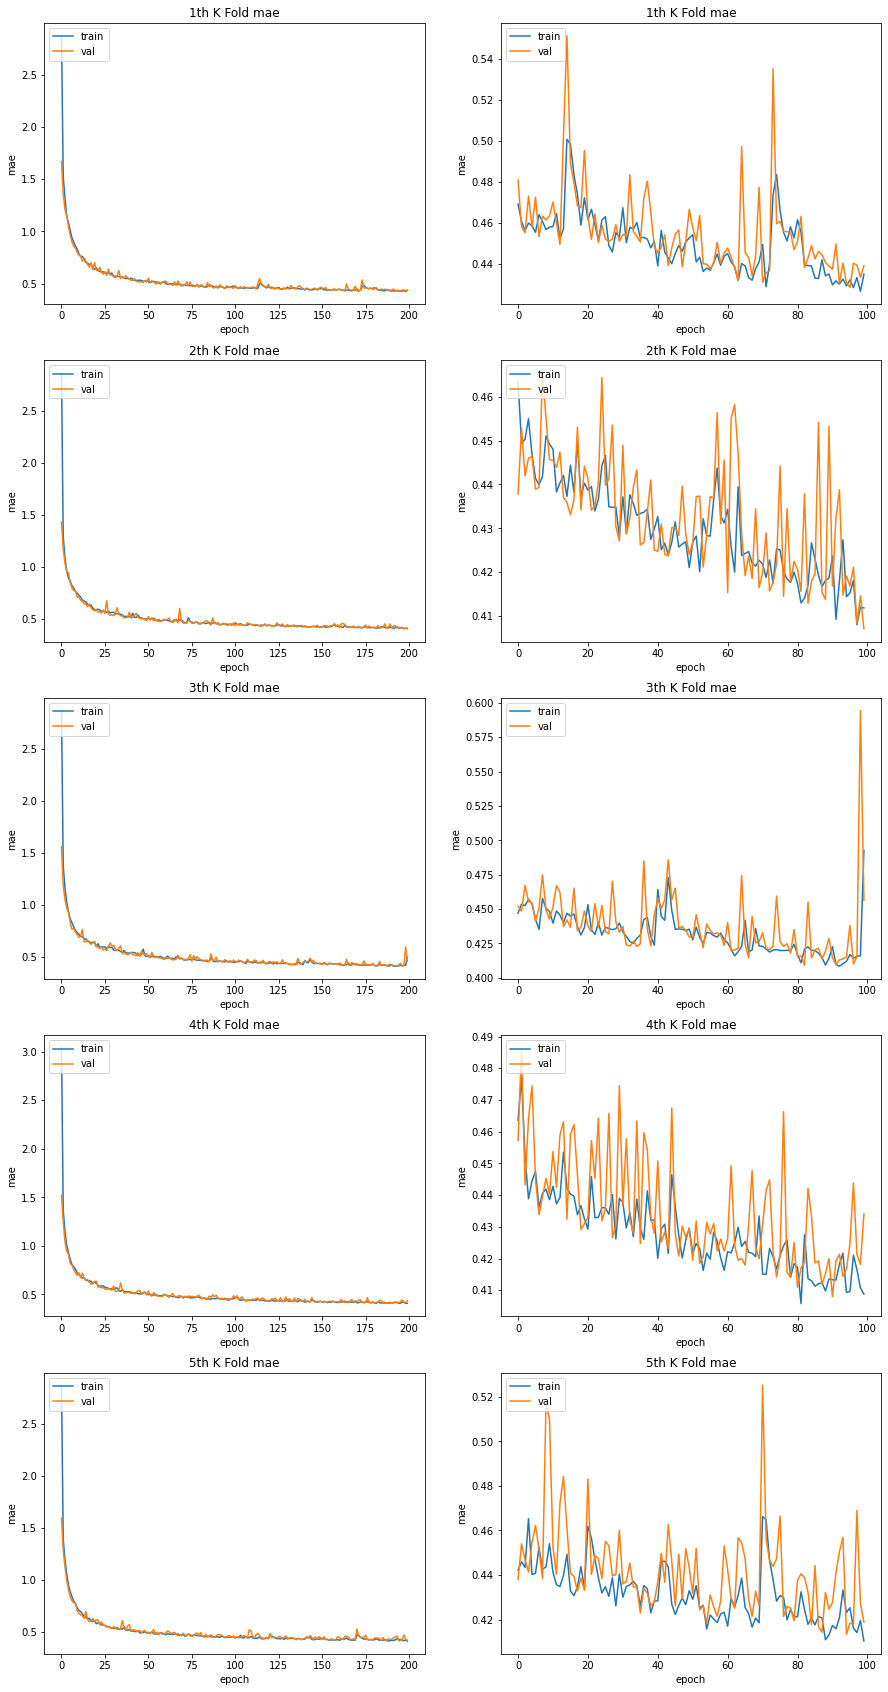

In [204]:
f,ax=plt.subplots(5, 2,figsize=(15, 30))

for i in range(5):
  ax[i, 0].set_title(str(i+1) + 'th K Fold mae')
  ax[i, 0].plot(history[str(i+1)].history['mean_absolute_error'])
  ax[i, 0].plot(history[str(i+1)].history['val_mean_absolute_error'])
  ax[i, 0].set_ylabel('mae')
  ax[i, 0].set_xlabel('epoch')
  ax[i, 0].legend(['train', 'val'], loc='upper left')

  ax[i, 1].set_title(str(i+1) + 'th K Fold mae')
  ax[i, 1].plot(history[str(i+1)].history['mean_absolute_error'][-100:])
  ax[i, 1].plot(history[str(i+1)].history['val_mean_absolute_error'][-100:])
  ax[i, 1].set_ylabel('mae')
  ax[i, 1].set_xlabel('epoch')
  ax[i, 1].legend(['train', 'val'], loc='upper left')

plt.show()

### Train by Major

In [ ]:
R_col = ['R5', 'R20', 'R50']
C_col = ['C10', 'C20', 'C50']
history={}

for r in R_col:
  for c in C_col:
    history[r+c] = training_byMajor(X_train_specialization[r+c], y_train_specialization[r+c], r+c, 
                                            learning_rate = learning_rate_model_byMajor, minibatch_size = minibatch_size_model_byMajor, num_epochs = num_epochs_model_byMajor)

In [ ]:
f,ax=plt.subplots(9, 5,figsize=(24, 40))
R_col = ['R5', 'R20', 'R50']
C_col = ['C10', 'C20', 'C50']

for r in R_col:
  for c in C_col:
      ax[i, j].set_title(r+c+'_' + 'th K Fold mae')
      ax[i, j].plot(history[r+c].history['mean_absolute_error'])
      ax[i, j].plot(history[r+c].history['val_mean_absolute_error'])
      ax[i, j].set_ylabel('mae')
      ax[i, j].set_xlabel('epoch')
      ax[i, j].legend(['train', 'val'], loc='upper left')

plt.show()

In [ ]:
f,ax=plt.subplots(9, 5,figsize=(24, 40))
R_col = ['R5', 'R20', 'R50']
C_col = ['C10', 'C20', 'C50']

for r in R_col:
  for c in C_col:
      ax[i, j].set_title(r+c+'_' + 'th K Fold mae')
      ax[i, j].plot(history[r+c].history['mean_absolute_error'][-100:])
      ax[i, j].plot(history[r+c].history['val_mean_absolute_error'][-100:])
      ax[i, j].set_ylabel('mae')
      ax[i, j].set_xlabel('epoch')
      ax[i, j].legend(['train', 'val'], loc='upper left')

plt.show()

### Train Stacking by Major

In [ ]:
R_col = ['R5', 'R20', 'R50']
C_col = ['C10', 'C20', 'C50']
history={}

for r in R_col:
  for c in C_col:
    history[r+c] = training_stacking_byMajor(X_train_specialization[r+c], y_train_specialization[r+c], r+c, 
                                            learning_rate = learning_rate_stacking_byMajor, minibatch_size = minibatch_size_stacking_byMajor, num_epochs = 300)

In [ ]:
f,ax=plt.subplots(3, 3,figsize=(15, 15))
R_col = ['R5', 'R20', 'R50']
C_col = ['C10', 'C20', 'C50']

i = -1
for r in R_col:
  i += 1
  j = -1
  for c in C_col:
      j += 1
      ax[i, j].set_title(r+c)
      ax[i, j].plot(history[r+c].history['mean_absolute_error'])
      ax[i, j].plot(history[r+c].history['val_mean_absolute_error'])
      ax[i, j].set_ylabel('mae')
      ax[i, j].set_xlabel('epoch')
      ax[i, j].legend(['train', 'val'], loc='upper left')

plt.show()

#### 10.29

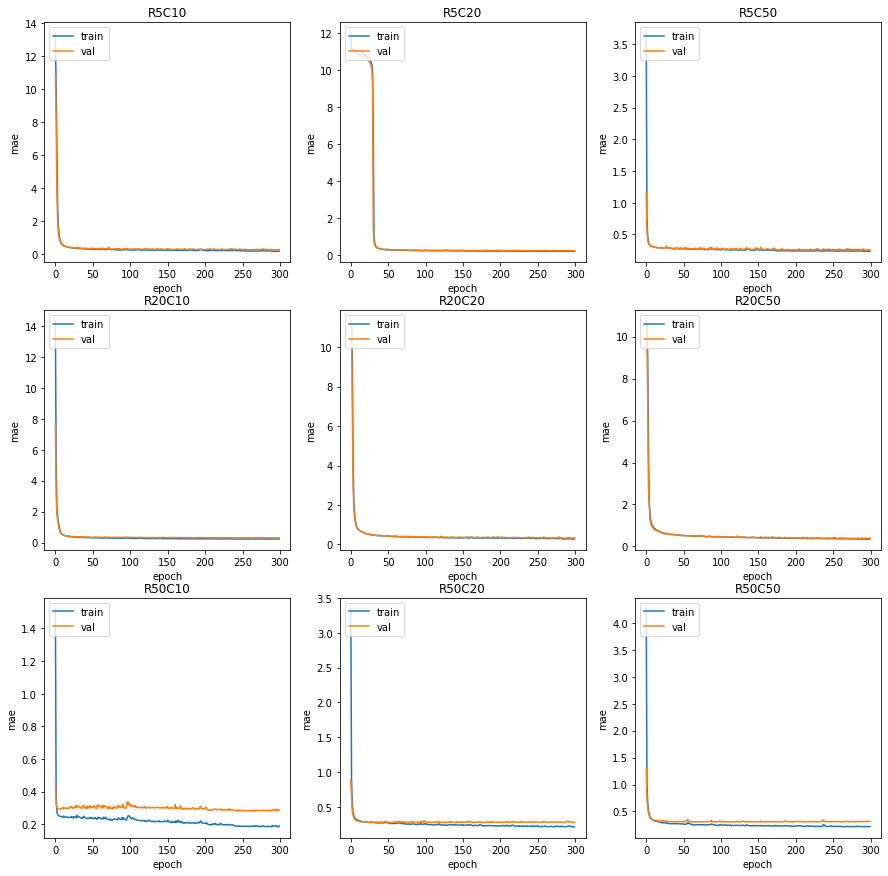

In [ ]:
f,ax=plt.subplots(3, 3,figsize=(15, 15))
R_col = ['R5', 'R20', 'R50']
C_col = ['C10', 'C20', 'C50']

i = -1
for r in R_col:
  i += 1
  j = -1
  for c in C_col:
      j += 1
      ax[i, j].set_title(r+c)
      ax[i, j].plot(history[r+c].history['mean_absolute_error'])
      ax[i, j].plot(history[r+c].history['val_mean_absolute_error'])
      ax[i, j].set_ylabel('mae')
      ax[i, j].set_xlabel('epoch')
      ax[i, j].legend(['train', 'val'], loc='upper left')

plt.show()

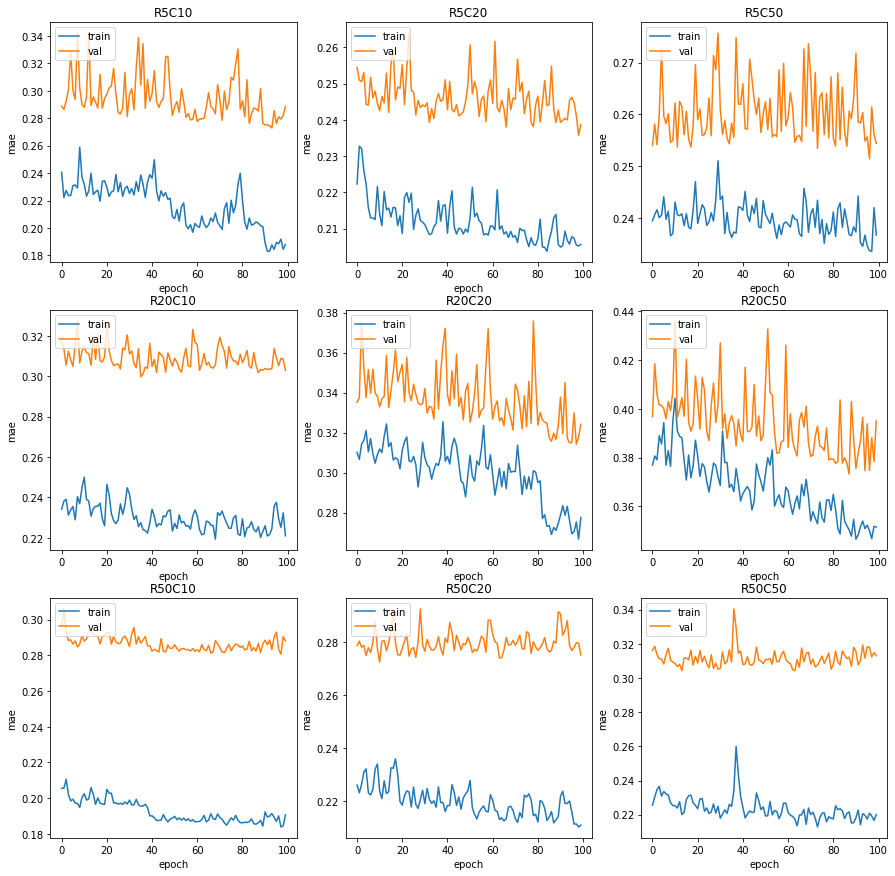

In [ ]:
f,ax=plt.subplots(3, 3,figsize=(15, 15))
R_col = ['R5', 'R20', 'R50']
C_col = ['C10', 'C20', 'C50']

i = -1
for r in R_col:
  i += 1
  j = -1
  for c in C_col:
      j += 1
      ax[i, j].set_title(r+c)
      ax[i, j].plot(history[r+c].history['mean_absolute_error'][-100:])
      ax[i, j].plot(history[r+c].history['val_mean_absolute_error'][-100:])
      ax[i, j].set_ylabel('mae')
      ax[i, j].set_xlabel('epoch')
      ax[i, j].legend(['train', 'val'], loc='upper left')

plt.show()

#### 10.28

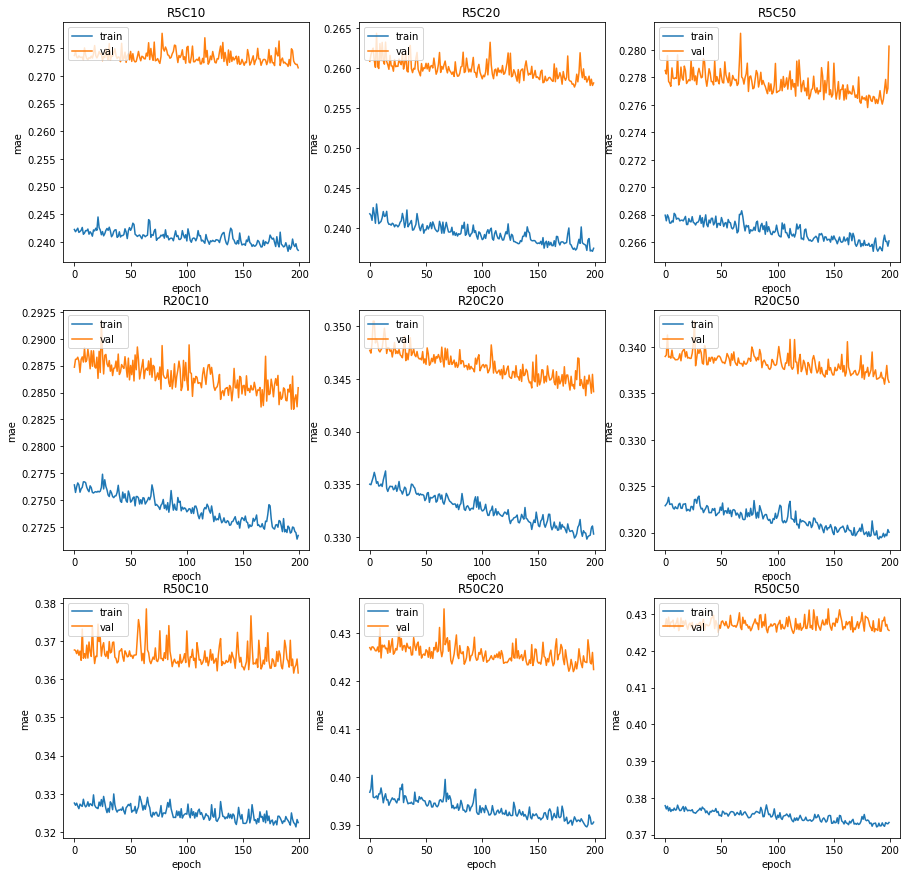

In [ ]:
f,ax=plt.subplots(3, 3,figsize=(15, 15))
R_col = ['R5', 'R20', 'R50']
C_col = ['C10', 'C20', 'C50']

i = -1
for r in R_col:
  i += 1
  j = -1
  for c in C_col:
      j += 1
      ax[i, j].set_title(r+c)
      ax[i, j].plot(history[r+c].history['mean_absolute_error'])
      ax[i, j].plot(history[r+c].history['val_mean_absolute_error'])
      ax[i, j].set_ylabel('mae')
      ax[i, j].set_xlabel('epoch')
      ax[i, j].legend(['train', 'val'], loc='upper left')

plt.show()

#### 10.26

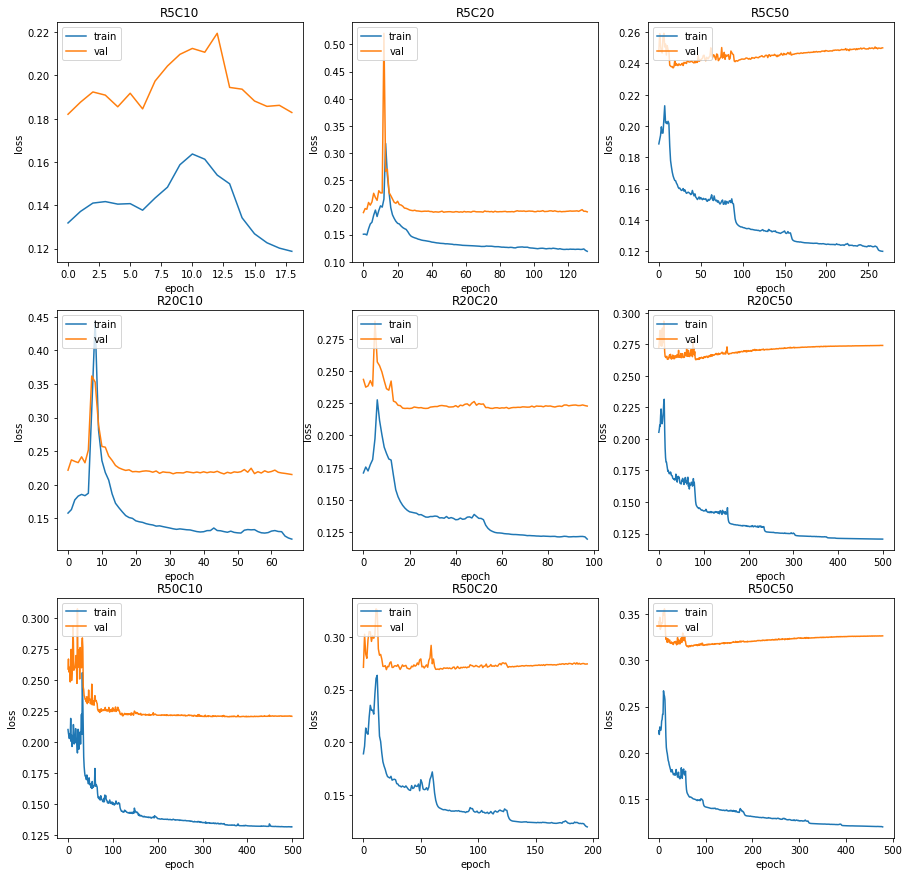

In [ ]:
# learning_rate_stacking_byMajor = 0.001
# minibatch_size_stacking_byMajor = 1024
# num_epochs_stacking_byMajor = 200
f,ax=plt.subplots(3, 3,figsize=(15, 15))
R_col = ['R5', 'R20', 'R50']
C_col = ['C10', 'C20', 'C50']

i = -1
for r in R_col:
  i += 1
  j = -1
  for c in C_col:
      j += 1
      ax[i, j].set_title(r+c)
      ax[i, j].plot(history[r+c].history['loss'])
      ax[i, j].plot(history[r+c].history['val_loss'])
      ax[i, j].set_ylabel('loss')
      ax[i, j].set_xlabel('epoch')
      ax[i, j].legend(['train', 'val'], loc='upper left')

plt.show()

#### 10.25

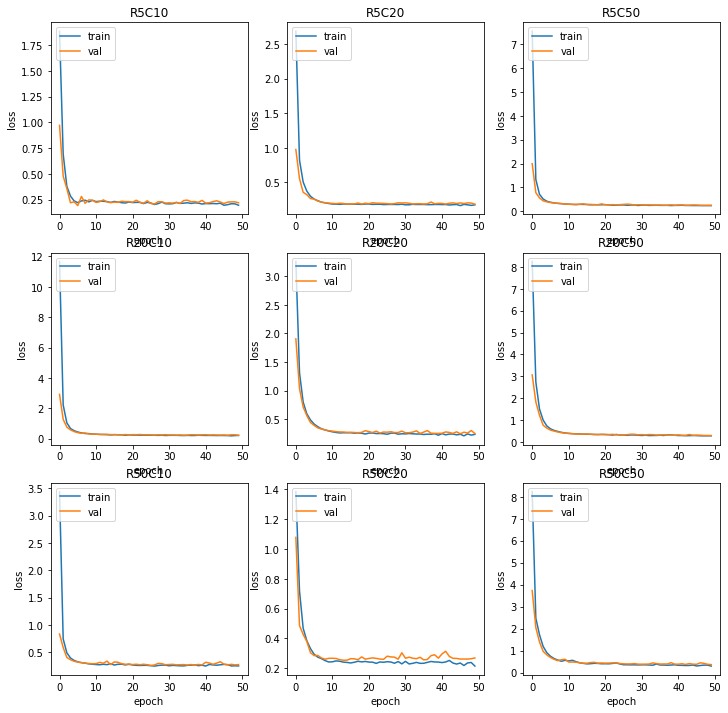

In [ ]:
# learning_rate_stacking_byMajor = 0.01
# minibatch_size_stacking_byMajor = 1024
# num_epochs_stacking_byMajor = 50
f,ax=plt.subplots(3, 3,figsize=(12, 12))
R_col = ['R5', 'R20', 'R50']
C_col = ['C10', 'C20', 'C50']

i = -1
for r in R_col:
  i += 1
  j = -1
  for c in C_col:
      j += 1
      ax[i, j].set_title(r+c)
      ax[i, j].plot(history[r+c].history['loss'])
      ax[i, j].plot(history[r+c].history['val_loss'])
      ax[i, j].set_ylabel('loss')
      ax[i, j].set_xlabel('epoch')
      ax[i, j].legend(['train', 'val'], loc='upper left')

plt.show()

### Train Stacking GH

In [ ]:
y_stack = Stack(X_train)

Calling Models
>> Model_R5C10
>> Model_R5C20
>> Model_R5C50
>> Model_R20C10
>> Model_R20C20
>> Model_R20C50
>> Model_R50C10
>> Model_R50C20
>> Model_R50C50
Models are predicting
>> Model_R5C10
>> Model_R5C20
>> Model_R5C50
>> Model_R20C10
>> Model_R20C20
>> Model_R20C50
>> Model_R50C10
>> Model_R50C20
>> Model_R50C50
<<<>>>STACKED<<<>>>


In [ ]:
history = training_stacking_GH(y_stack, y_train, 
                                    learning_rate = learning_rate_stacking_GH, minibatch_size = minibatch_size_stacking_GH, num_epochs = num_epochs_stacking_GH)

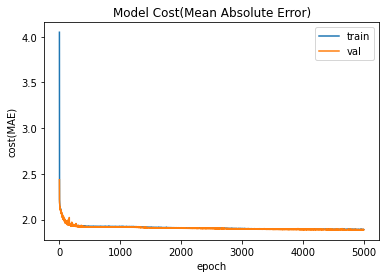

In [ ]:
# learning_rate_stacking_GH = 0.001
# minibatch_size_stacking_GH = 4048
# num_epochs_stacking_GH = 500

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Cost(Mean Absolute Error)')
plt.ylabel('cost(MAE)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Prediction

In [ ]:
R_col = ['R5', 'R20', 'R50']
C_col = ['C10', 'C20', 'C50']
predictions={}

for r in R_col:
  for c in C_col:
    Model = call_stacking_byMajor(r+c)
    print(">> Model", r+c)
    prediction = Model.predict(X_test_specialization[r+c], batch_size=1000)
    predictions[r+c] = np.ravel(prediction)

In [ ]:
submission.loc[id_R5C10 - 1, 'pressure'] = predictions['R5C10']
submission.loc[id_R5C20 - 1, 'pressure'] = predictions['R5C20']
submission.loc[id_R5C50 - 1, 'pressure'] = predictions['R5C50']

submission.loc[id_R20C10 - 1, 'pressure'] = predictions['R20C10']
submission.loc[id_R20C20 - 1, 'pressure'] = predictions['R20C20']
submission.loc[id_R20C50 - 1, 'pressure'] = predictions['R20C50']

submission.loc[id_R50C10 - 1, 'pressure'] = predictions['R50C10']
submission.loc[id_R50C20 - 1, 'pressure'] = predictions['R50C20']
submission.loc[id_R50C50 - 1, 'pressure'] = predictions['R50C50']

In [ ]:
submission

,id,pressure
0,1,6.210083
1,2,6.274246
2,3,7.262769
3,4,7.791946
4,5,9.215157
...,...,...
4023995,4023996,6.183650
4023996,4023997,6.366447
4023997,4023998,6.206474
4023998,4023999,6.195194


In [ ]:
submission.to_csv('/content/drive/MyDrive/Ventilator_Pressure_Prediction/submission_ver1029_02.csv', index=False)

In [ ]:
# X_stack_test = stack_one_step(X_test)

In [ ]:
"""
Model_stacking = call_stackingModel_special(learning_rate_stacking)
prediction = Model_stacking.predict([X_test, X_stack_test])
submission['pressure'] = prediction #_flat
"""